# what does this notebook do:
1. load the data, 
2. process the data for the following steps.
3. registration
    step 1. run point set matching (ICP)  
    step 2. tune the consensus set parameters.  
    step 3. run maximum-rotation-set  
    step 4. neighborhood matching  
    step 5. find the non-rigid transformation  
4. count the matching cells. 

In [1]:
import pickle
import numpy as np
import time,sys,glob,os
import pandas as pd
import scipy.ndimage as ndi
import cc3d
import cv2
import open3d as o3d

from skimage import color, morphology, measure
from skimage.transform import downscale_local_mean
from skimage.registration import phase_cross_correlation

from scipy.stats import zscore
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from cellregister import *
from iterive_non_rigid import *

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 1. load the data
- we will need four data as pickle files, including the two original images (`img1.pkl` and `img2.pkl`) and two segmented images (`img1_seg.pkl` and `img2_seg.pkl`).
- note that the two images do not need to be on the same size but the corresponding segmented images have to be. 
- we use `z` and `nd2` to refer these two *in vivo* and *ex vivo* images.

In [ ]:
data_dir = './data/' # put your data here. 
z_f = pickle.load(open(data_dir + '/img1.pkl', 'rb'))
nd2_f = pickle.load(open(data_dir + '/img2.pkl', 'rb'))
seg_cc_f_zstack = pickle.load(open(data_dir + '/img1_seg.pkl', 'rb'))
seg_cc_f_nd2 = pickle.load(open(data_dir + '/img1_seg.pkl', 'rb'))


# 2. Setup
set up the parameters here. 

In [4]:
add_edge = np.array((10,100,100))
outputshape = add_edge*2

max_iteration = 100  # shape ICP max iteration 
thre = 3 # shape ICP parametrs
ds_sz = 5 # shape ICP downsample size
with_scaling = True # shape ICP learn the scaling 
ds_sz_aff=3 # NCC downsample size
vec_ds = 3 # vector field downsample size. 

# 3. Process two images
- this will generate the variables needed in the following steps. 

In [5]:
zstack_mask,zstack_dims,zstack_cells,zstack_bb,num_cells_list_zstack,pcd_j_ds_list,im2p_list=generate_stuff(z_f,seg_cc_f_zstack, add_edge, ds_sz, outputshape, ds_sz_aff)
nd2_mask,nd2_dims,nd2_cells,nd2_bb,num_cells_list_nd2,pcd_i_ds_list,im1p_list=generate_stuff(nd2_f,seg_cc_f_nd2, add_edge, ds_sz, outputshape, ds_sz_aff)



# 4. registration 
### step 1. point cloud matching using shape and context information
the following code runs ICP and get NCC for each pairs. By default we only consider cases where more than 6 cells appear in the same patch. 

In [6]:
transform_mtx_list = run_shape_icp(pcd_j_ds_list,num_cells_list_zstack,
                                   pcd_i_ds_list,num_cells_list_nd2, thre)

/home/ubuntu/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [7]:
icp_NCC = run_tranform_get_NCC(transform_mtx_list,ds_sz_aff, 
                               im2p_list,im1p_list)


/home/ubuntu/code/cellregister.py:31: RuntimeWarning: invalid value encountered in true_divide
  out = out/np.std(foo)


### step 2. find the consensus set and save the file 
we find the co-apperance matrix and create the files to run MRS from MATLAB.   
`find_consensus_parameters` will find the best parameters for the co-apperance matrix

In [8]:
im_cent_zstack = get_cellcent(seg_cc_f_zstack)
im_cent_nd2 = get_cellcent(seg_cc_f_nd2)
final_d_thre,final_thresh,appearance_matrix = find_consensus_parameters(icp_NCC,im_cent_zstack,im_cent_nd2,
                                                                          seg_cc_f_zstack,zstack_bb,zstack_cells,
                                                                          seg_cc_f_nd2,nd2_bb,nd2_cells,
                                                                          add_edge=add_edge)

final distance threshold = 20
final coappearance threshold = 2


and save the mat files. 

In [10]:
max_rot_set_f = f'./MRS/'
if not os.path.exists(max_rot_set_f):
    os.mkdir(max_rot_set_f)    
save_MRS_file(max_rot_set_f, im_cent_zstack,im_cent_nd2,appearance_matrix,final_thresh)

now run maximum-rotation-set (MRS) from `run_MRS.m` to find the exact matching 

In [ ]:
! /Applications/MATLAB_R2021a.app/bin/matlab -nojvm -nodesktop -nosplash -r "run_MRS"

load the MRS results.

In [12]:
bhat,X_p,Y_p = get_exact_matching_from_MRS(max_rot_set_f, im_cent_zstack,im_cent_nd2, appearance_matrix,final_thresh)

### step 3. neighborhood matching 
- we use the final consensus set coordinates and get their neighbors.
- initialize all the coordinates with the consensus set transformation results.
- then we can get the final transformation!
- we apply this final transformation to the original img1

In [13]:
set1p_cent, set2p_cent =get_neighbor_coord(im_cent_zstack,im_cent_nd2,z_f,X_p,Y_p)
tran, im1_wahba = run_doubleICP(z_f, nd2_f, bhat, set1p_cent, set2p_cent)  # this is the consensus matching results. 
total_R, total_shift, total_scale = get_final_transformation(tran,bhat)  

In [14]:
# print out the final results. 
print('rotation matrix:\n',total_R)
print(f'scale:\n{total_scale}')
print('shift:\n',total_shift)
print(f'euler (radiant):\n{rotationMatrixToEulerAngles(total_R/total_scale)}')
print(f'euler (degree):\n{angles(rotationMatrixToEulerAngles(total_R/total_scale))}')

rotation matrix:
 [[ 0.91733773  0.19900023 -0.06399283]
 [-0.19989492  0.91934953 -0.00656929]
 [ 0.06114077  0.0200011   0.9386514 ]]
scale:
0.9408531690761168
shift:
 [-265.78329172   47.0750209    64.48658832]
euler (radiant):
[-0.21455369 -0.06503022  0.02130512]
euler (degree):
[-12.293  -3.726   1.221]


In [15]:
im1_happy = apply_total_R(z_f,nd2_f, total_R, total_shift)
im1_bi_happy = apply_doubleICP_2_binary(seg_cc_f_zstack,seg_cc_f_nd2,total_R,total_shift)

### step 4. iterative non-rigid transformation

iteration 0...


/home/ubuntu/miniconda3/envs/py3/lib/python3.9/site-packages/skimage/registration/_phase_cross_correlation.py:104: RuntimeWarning: invalid value encountered in cdouble_scalars
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\


iteration 5...
iteration 10...
iteration 15...
iteration 20...
iteration 25...


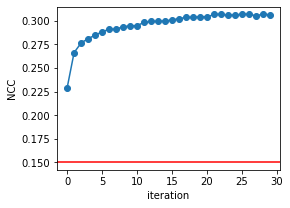

In [17]:
# this will print out the total NCC over the iterations`
img_de,z_de,ncc_list,vec_field_smooth_list = learn_and_apply_deformable(im1_happy,nd2_f,vec_ds)


lets look at the registered results

WARNING - 2022-02-27 21:16:50,206 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - 2022-02-27 21:16:50,586 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - 2022-02-27 21:16:51,182 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


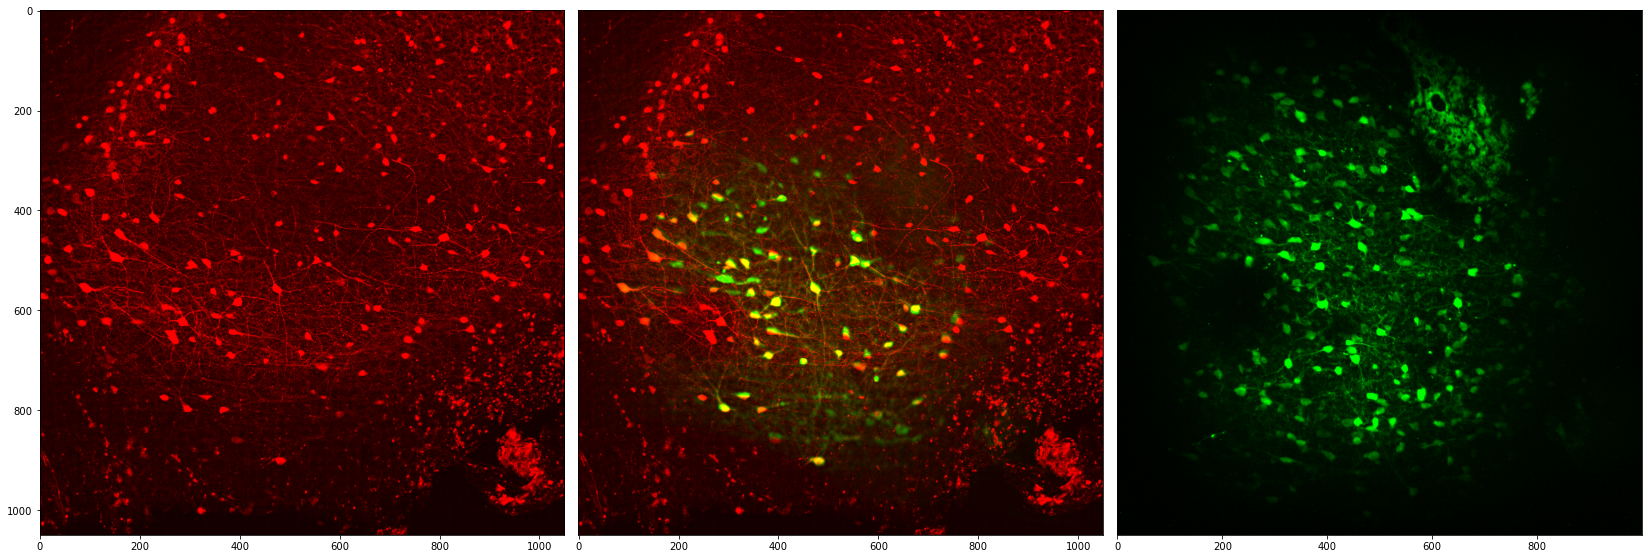

In [18]:
scl_1 =0.1
scl_2 =0.2
plt.figure(figsize = (23,11))
plt.subplot(1,3,1)
plt.imshow(gray2RGB(nd2_f, col='r',scl = scl_1) )
plt.subplot(1,3,2)
plt.imshow(gray2RGB(nd2_f, col='r',scl = scl_1) + 
           gray2RGB(z_de, col = 'g', scl = scl_2))
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(gray2RGB(z_f, col = 'g', scl = scl_2))
plt.yticks([])
plt.tight_layout()

### step 5. count the matching cells. 


In [19]:

# first we apply the non-rigid transformation to the binary image too.
z_bi_de = apply_deformable_2_binary(im1_happy,im1_bi_happy,
                                    seg_cc_f_zstack,seg_cc_f_nd2,
                                    vec_ds,vec_field_smooth_list)

# then count the number of matchings. 
cc_im1,cc_im2,closest_pair,z_cent_new = count_cell_matching(z_bi_de, seg_cc_f_nd2)


***FOUND PAIRS:*** 47
